In [156]:
import pandas as pd
import numpy as np
import bootcampviztools as bt
import matplotlib.pyplot as plt
import seaborn as sns
import TeamChallenge_ML_completo as tc

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


import warnings

# Suprime todos los warnings
warnings.filterwarnings("ignore")

### obtener los datos

In [157]:
df_train = pd.read_csv("./data/train.csv", index_col=0)
df_train.index.name = None
df_test = pd.read_csv("./data/test.csv", index_col=0)
df_test.index.name = None

In [158]:
df_train.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [159]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [160]:
target = "Price_in_euros"
cat_col = ["Company", "Product", "TypeName", "ScreenResolution", "Cpu", "Memory", "Gpu", "OpSys"]

### minieda

In [161]:
for col in cat_col:
    print(col, df_train[col].nunique())

Company 19
Product 480
TypeName 6
ScreenResolution 36
Cpu 107
Memory 37
Gpu 93
OpSys 9


tengo columnas categoricas con muchos valores únicos

In [162]:
# el nombre del modelo me lo quito

cat_col.remove("Product")

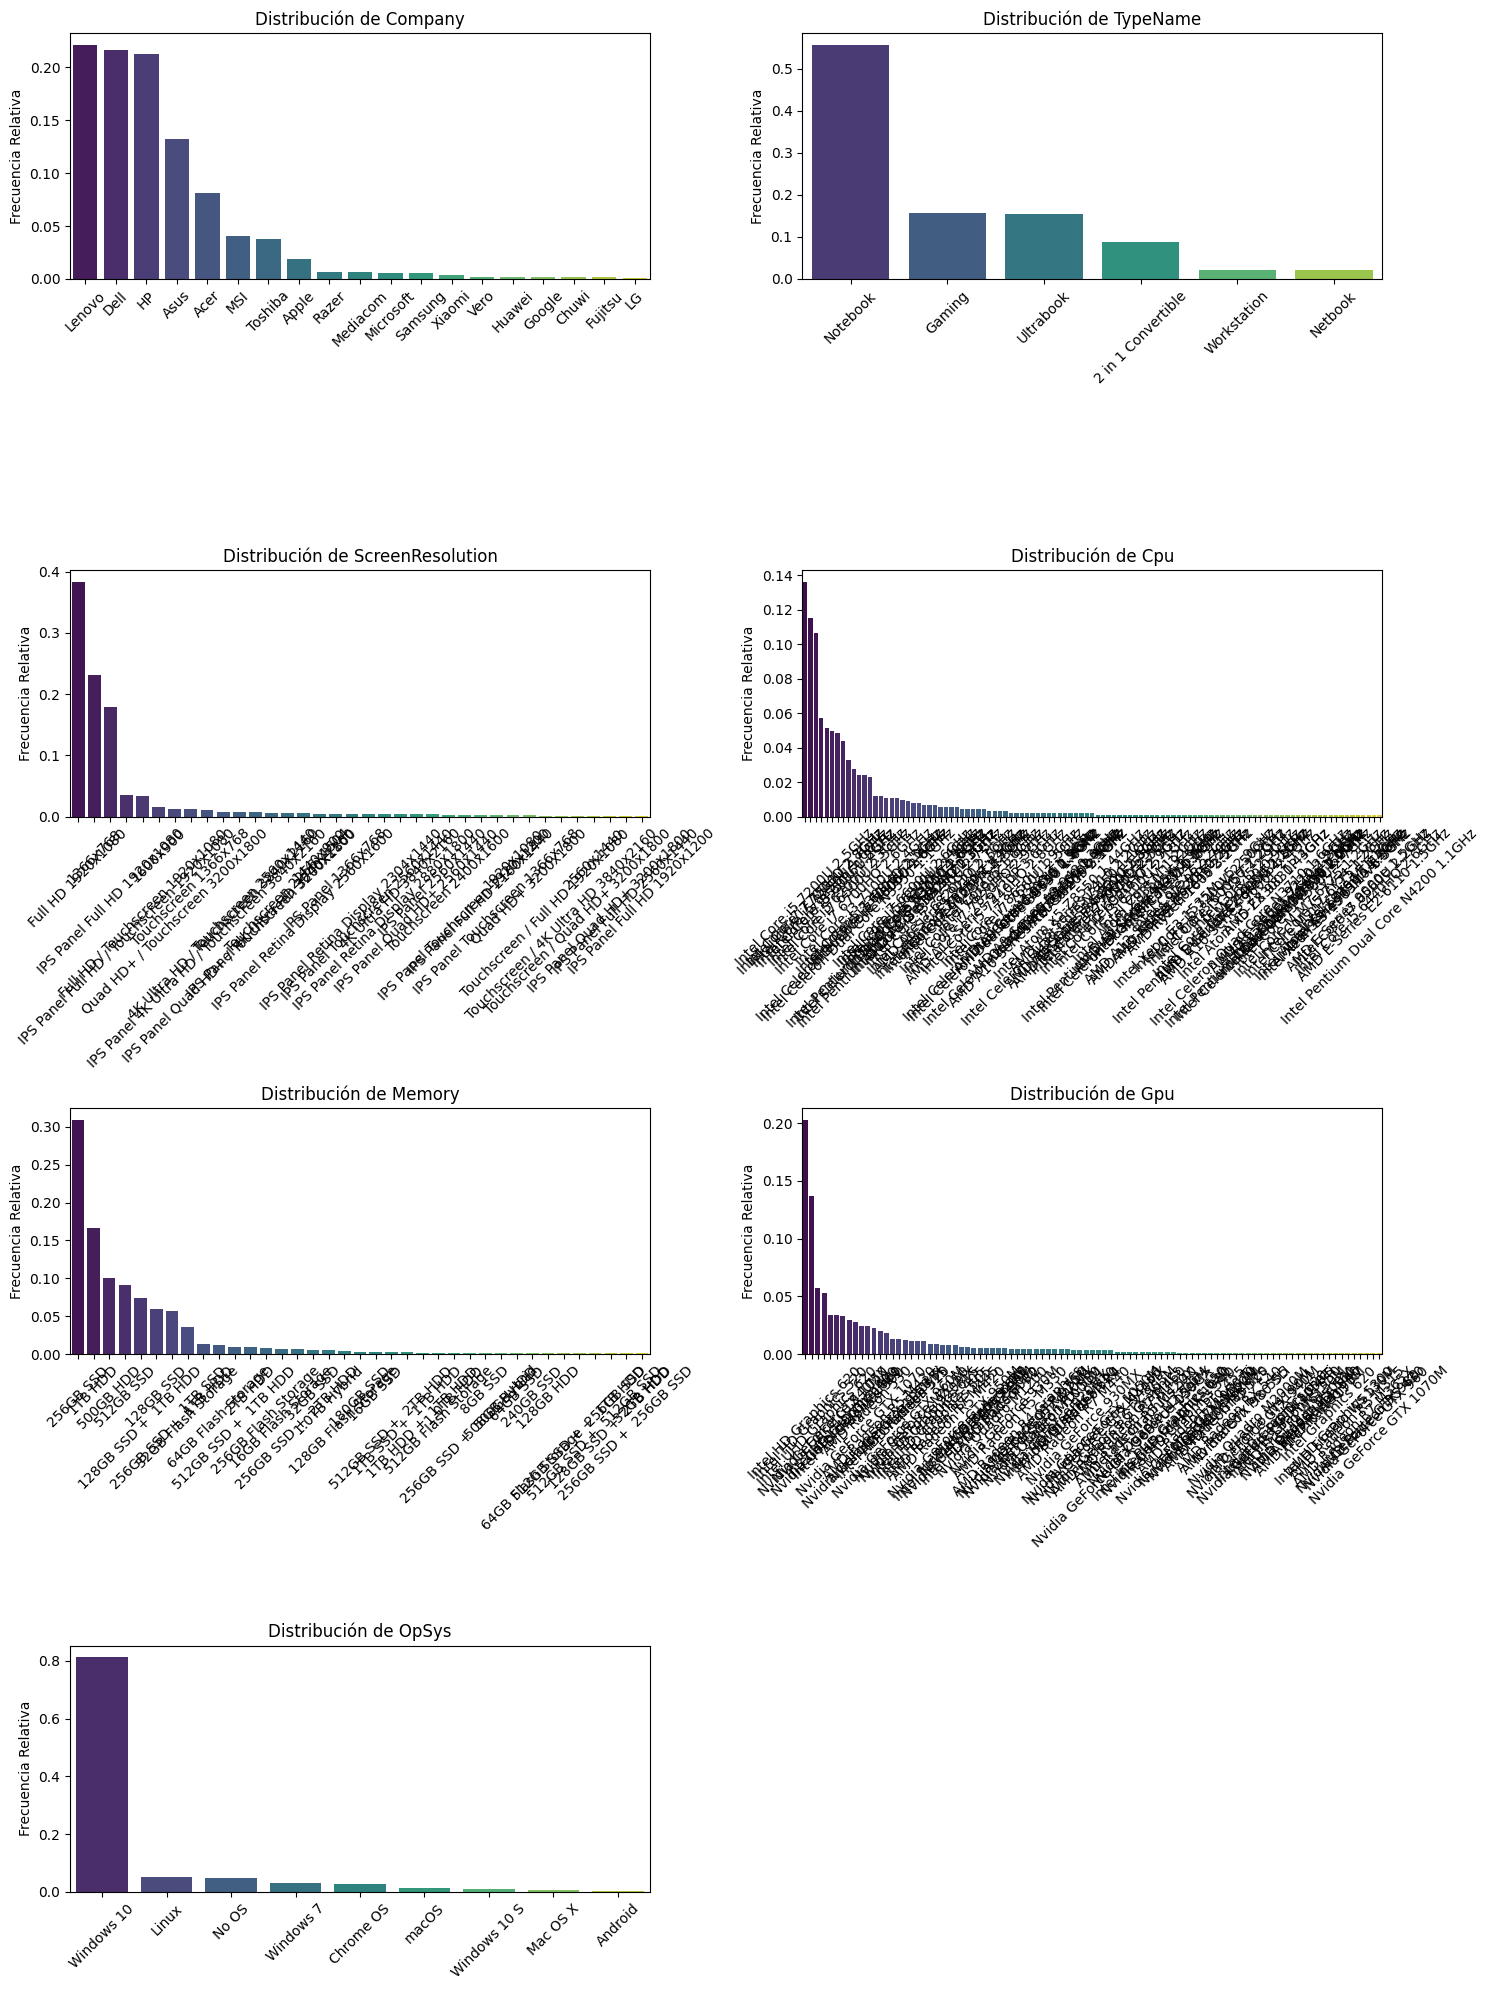

In [163]:
bt.pinta_distribucion_categoricas(df_train, cat_col, relativa=True)

#### screen resolution

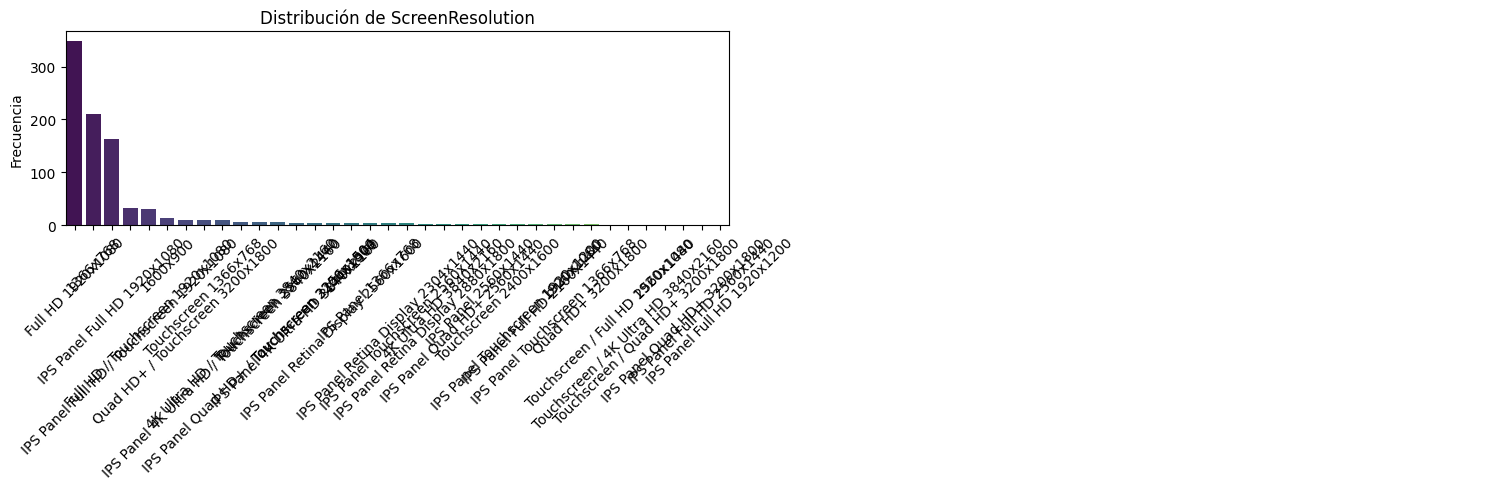

In [164]:
bt.pinta_distribucion_categoricas(df_train, ["ScreenResolution"])

In [165]:
df_train['retina'] = df_train['ScreenResolution'].str.contains('Retina').astype(int)
df_train['ips'] = df_train['ScreenResolution'].str.contains('IPS').astype(int)
df_train['touchscreen'] = df_train['ScreenResolution'].str.contains('Touchscreen').astype(int)


In [166]:
df_train['ScreenResolution'] = df_train['ScreenResolution'].str.extract(r'(\b\d{3,4}x\d{3,4}\b)', expand=False)


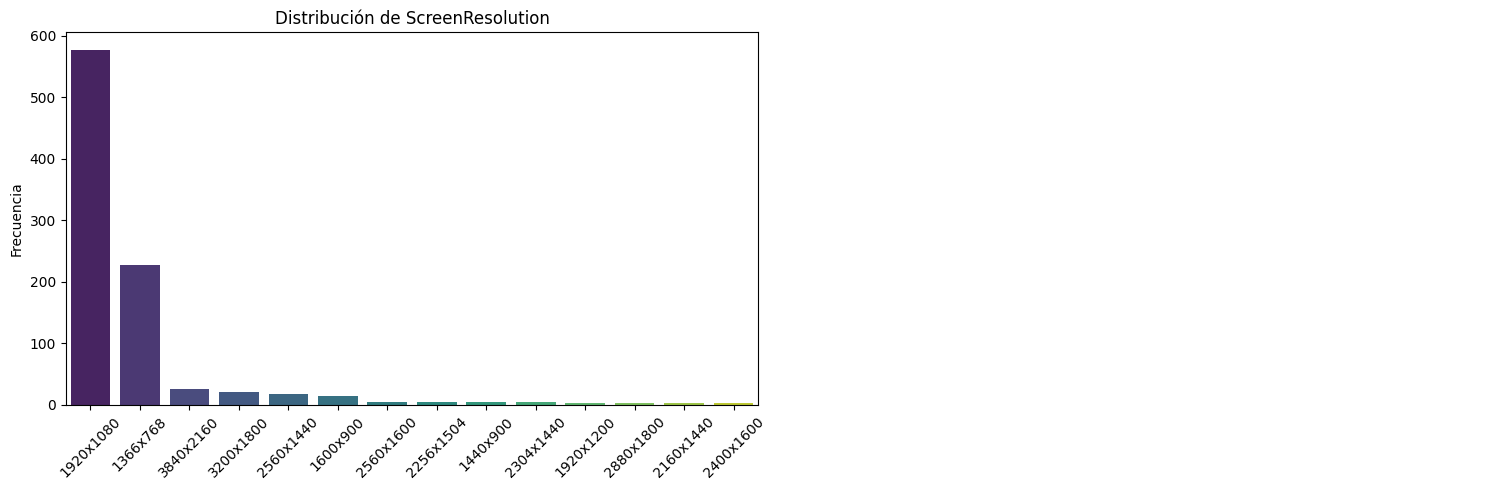

In [167]:
bt.pinta_distribucion_categoricas(df_train, ["ScreenResolution"])

#### memoria

In [168]:
df_train.Memory.value_counts()

Memory
256GB SSD                        282
1TB HDD                          152
500GB HDD                         92
512GB SSD                         83
128GB SSD +  1TB HDD              67
128GB SSD                         54
256GB SSD +  1TB HDD              52
32GB Flash Storage                33
1TB SSD                           12
64GB Flash Storage                11
512GB SSD +  1TB HDD               8
2TB HDD                            8
256GB Flash Storage                7
16GB Flash Storage                 6
256GB SSD +  2TB HDD               6
32GB SSD                           5
1.0TB Hybrid                       5
128GB Flash Storage                4
180GB SSD                          3
16GB SSD                           3
512GB SSD +  2TB HDD               2
1TB SSD +  1TB HDD                 2
1TB HDD +  1TB HDD                 1
512GB Flash Storage                1
1.0TB HDD                          1
256GB SSD +  500GB HDD             1
8GB SSD                        

#### cpu

In [169]:
df_train.Cpu.value_counts(
)

Cpu
Intel Core i5 7200U 2.5GHz              124
Intel Core i7 7700HQ 2.8GHz             105
Intel Core i7 7500U 2.7GHz               97
Intel Core i5 8250U 1.6GHz               52
Intel Core i7 8550U 1.8GHz               47
                                       ... 
AMD E-Series 9000e 1.5GHz                 1
Intel Core i7 6560U 2.2GHz                1
Intel Core i5 6440HQ 2.6GHz               1
AMD E-Series E2-6110 1.5GHz               1
Intel Pentium Dual Core N4200 1.1GHz      1
Name: count, Length: 107, dtype: int64

In [170]:
# aqui veo que todos los procesadores son intel y amd y me informo un poquito al respecto

mask_intel = df_train['Cpu'].str.contains('Intel')
mask_amd = df_train['Cpu'].str.contains('AMD')

In [171]:
# me voy a quedar solo con la marca y los ghz

cepeu = df_train['Cpu'].str.extract(r'([A-Za-z]+)\s.*\s([0-9.]+)GHz')
cepeu

,0,1
755,Intel,2
618,Intel,2.6
909,Intel,2.7
2,Intel,1.8
286,Intel,2.0
...,...,...
28,Intel,1.6
1160,Intel,2.4
78,Intel,2.5
23,AMD,1.5


In [172]:
cepeu[1] = cepeu[1].astype(float)

In [173]:
"""
orientativo segun chat gpt

Para procesadores Intel:

Alta gama: Velocidad de reloj mayor a 3.0 GHz
Media gama: Velocidad de reloj entre 2.0 GHz y 3.0 GHz
Baja gama: Velocidad de reloj menor a 2.0 GHz
Para procesadores AMD:

Alta gama: Velocidad de reloj mayor a 3.2 GHz
Media gama: Velocidad de reloj entre 2.0 GHz y 3.2 GHz
Baja gama: Velocidad de reloj menor a 2.0 GHz
"""
cepeu['Categoria'] = pd.cut(cepeu[1], bins=[-float('inf'), 2, 3, float('inf')], labels=[3,2,1])


In [174]:
cepeu["Categoria"] = cepeu["Categoria"].astype(object)

In [175]:
cepeu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   0          912 non-null    object 
 1   1          912 non-null    float64
 2   Categoria  912 non-null    object 
dtypes: float64(1), object(2)
memory usage: 28.5+ KB


In [176]:
df_train["cpu"] = cepeu[0] + " " + cepeu["Categoria"].astype(str)


#### gpu


In [177]:
df_train.Gpu.value_counts()

Gpu
Intel HD Graphics 620       185
Intel HD Graphics 520       125
Intel UHD Graphics 620       52
Nvidia GeForce GTX 1050      48
Nvidia GeForce 940MX         31
                           ... 
AMD Radeon R7 M365X           1
Nvidia GeForce GTX 980        1
Nvidia GeForce GTX 960        1
AMD Radeon R5 430             1
Nvidia GeForce GTX 1070M      1
Name: count, Length: 93, dtype: int64

In [178]:
mask_intel = df_train['Gpu'].str.contains('Intel')
mask_amd = df_train['Gpu'].str.contains('AMD')
mask_nvidia = df_train["Gpu"].str.contains("Nvidia")

mask_combi = mask_intel | mask_amd | mask_nvidia

df_train[~mask_combi]
# solo hay 3 marcas

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,retina,ips,touchscreen,cpu


In [179]:
df_train['gpu'] = df_train['Gpu'].str.split().str[0]

In [180]:
df_train.head(1)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros,retina,ips,touchscreen,cpu,gpu
755,HP,250 G6,Notebook,15.6,1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.0,0,0,0,Intel 3,Intel


In [181]:
cat_feat = ["Company", "TypeName", "OpSys", "retina", "ips", "touchscreen", "cpu", "gpu"]

#### numericas

In [182]:
# Memory

def convert_to_gb(memory):
    total_gb = 0
    capacities = memory.split('+')
    for capacity in capacities:
        if 'TB' in capacity:
            total_gb += int(float(capacity.split('TB')[0]) * 1024)
        elif 'GB' in capacity:
            total_gb += int(float(capacity.split('GB')[0]))
    return total_gb


df_train['storage_gb'] = df_train['Memory'].apply(convert_to_gb)

In [183]:
df_train["ram_gb"] =  df_train["Ram"].str.replace("GB", "").astype(int)
df_train["weight_kg"]= df_train["Weight"].str.replace("kg", "").astype(float)

In [184]:
num_feat = ["storage_gb", "ram_gb", "weight_kg"]

In [185]:
train, val = train_test_split(df_train[num_feat+cat_feat+[target]], test_size=.2, random_state=42)


### eda con las columnas nuevas

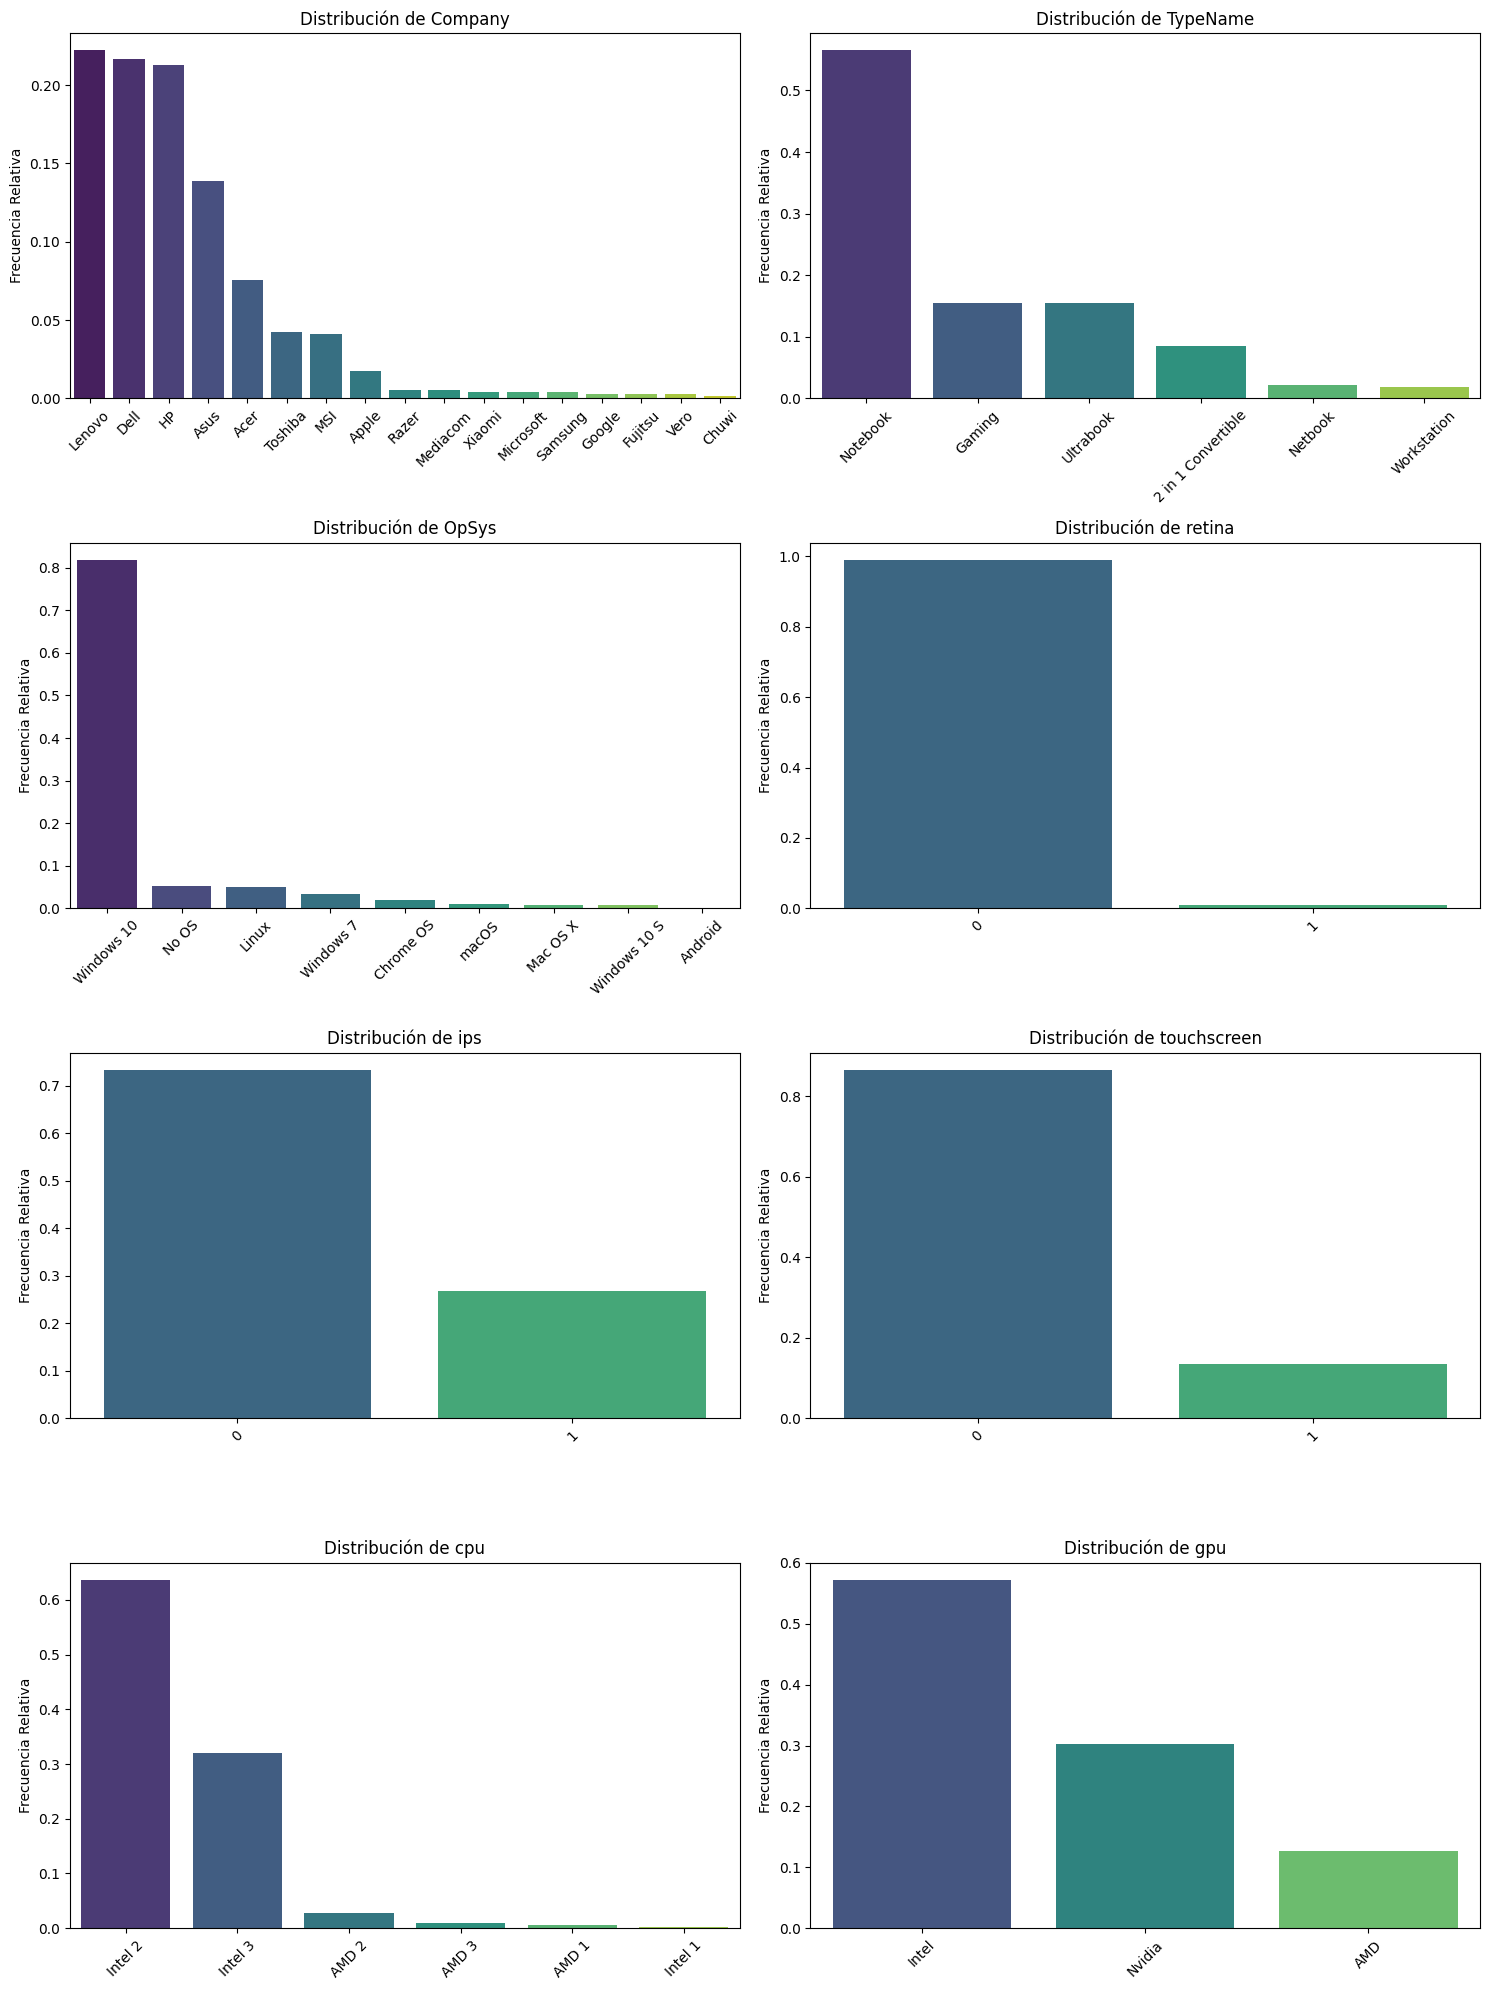

In [186]:
bt.pinta_distribucion_categoricas(train, cat_feat, relativa=True)

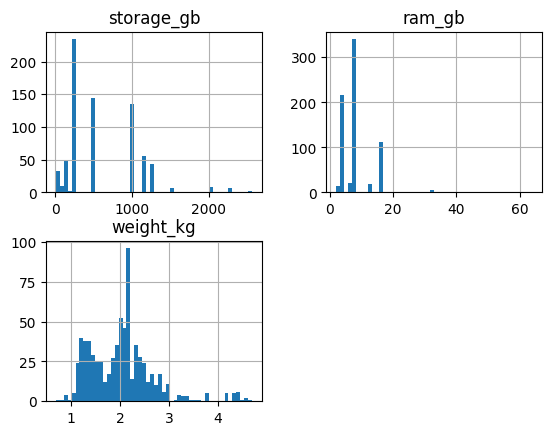

In [187]:
train[num_feat].hist(bins=50);

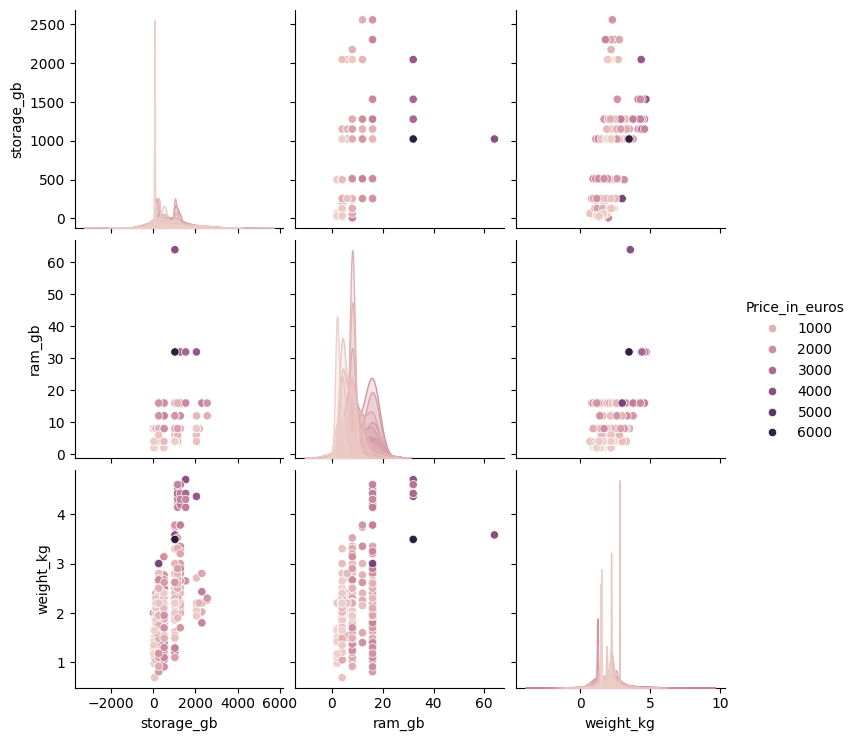

In [188]:
sns.pairplot(train[num_feat+[target]], hue=target)

In [189]:
cat_feat

['Company', 'TypeName', 'OpSys', 'retina', 'ips', 'touchscreen', 'cpu', 'gpu']

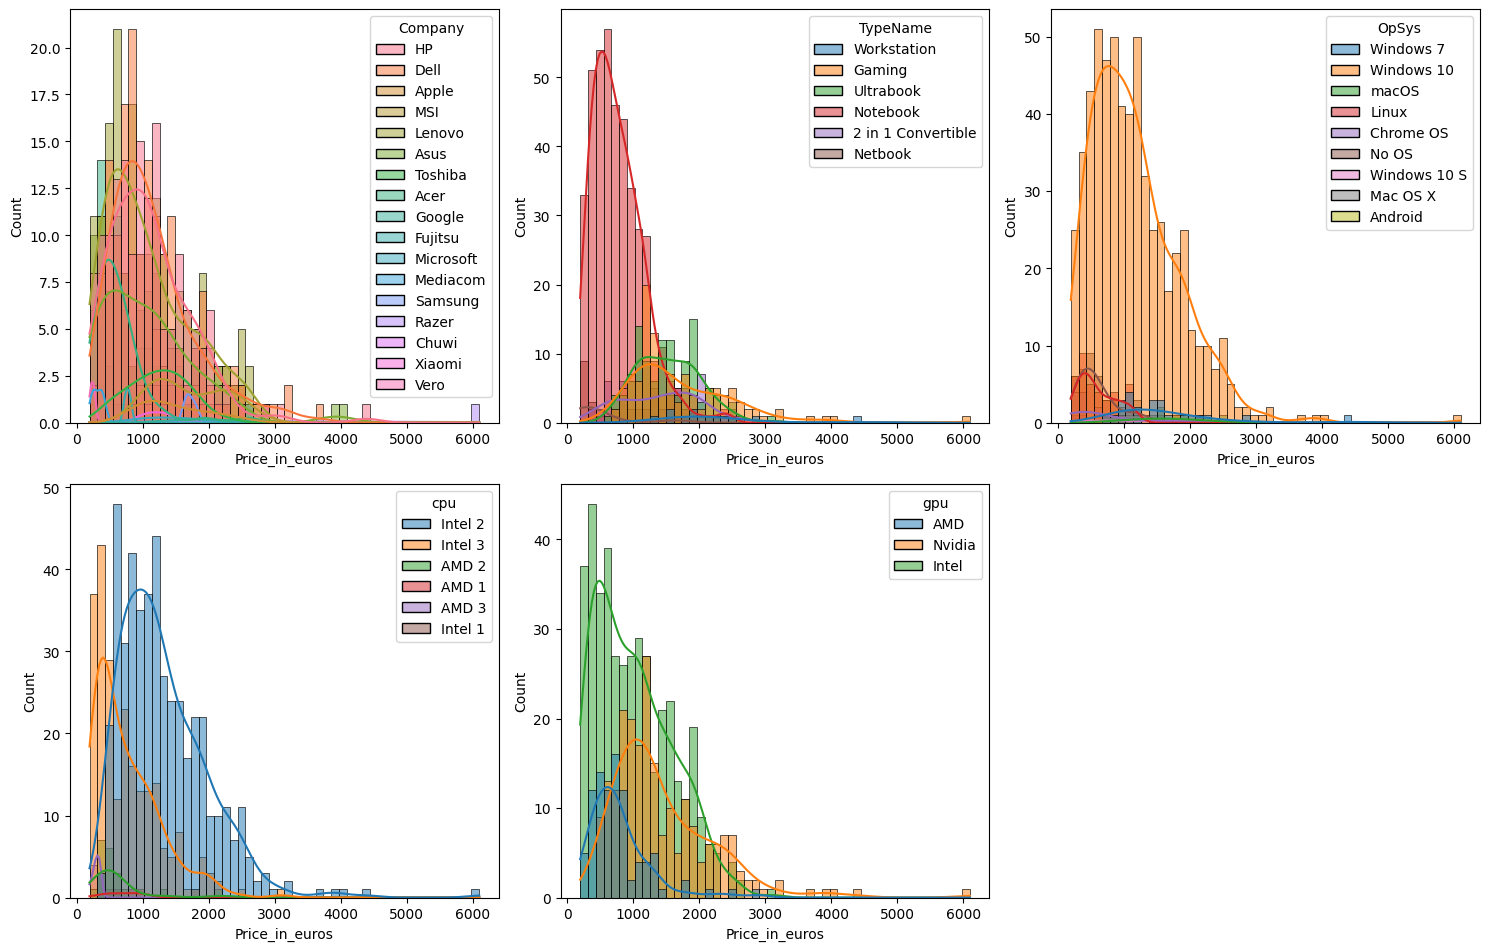

['Company', 'TypeName', 'OpSys', 'cpu', 'gpu']

In [190]:
tc.plot_features_cat_regression(train, target, cat_feat, 1)

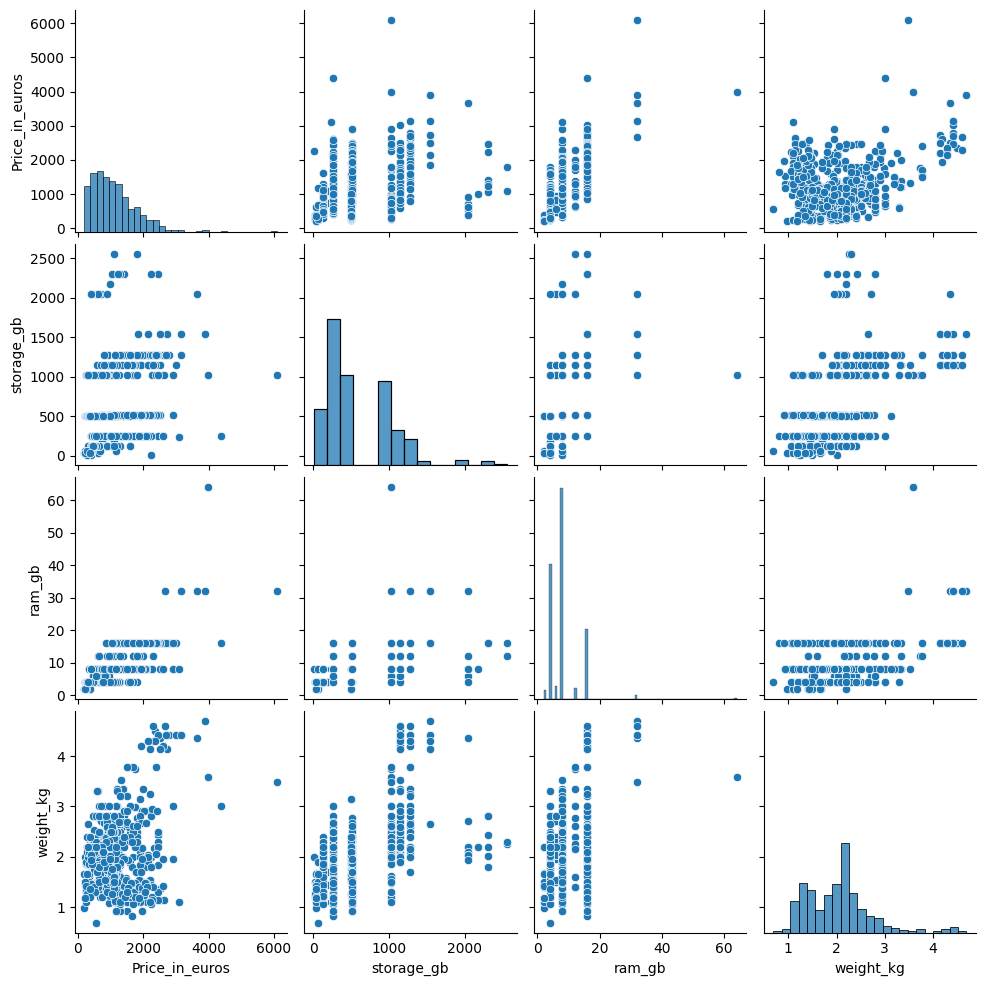

['storage_gb', 'ram_gb', 'weight_kg']

In [191]:
tc.plot_features_num_regression(train, target, num_feat)

### modelado

In [192]:
X_train = train[num_feat + cat_feat].copy()
y_train = train[target].copy()

X_val = val[num_feat+cat_feat].copy()
y_val = val[target].copy()

In [193]:
X_train

,storage_gb,ram_gb,weight_kg,Company,TypeName,OpSys,retina,ips,touchscreen,cpu,gpu
1118,1024,8,3.00,HP,Workstation,Windows 7,0,1,0,Intel 2,AMD
153,512,16,2.56,Dell,Gaming,Windows 10,0,0,0,Intel 2,Nvidia
275,512,8,1.37,Apple,Ultrabook,macOS,1,1,0,Intel 2,Intel
1100,500,4,1.54,HP,Notebook,Windows 7,0,0,0,Intel 2,Intel
131,2304,16,2.80,Dell,Notebook,Windows 10,0,0,0,Intel 3,AMD
...,...,...,...,...,...,...,...,...,...,...,...
578,2048,8,1.94,HP,Notebook,Windows 10,0,0,0,Intel 3,Intel
996,256,6,2.20,Lenovo,Notebook,Windows 10,0,0,0,AMD 1,AMD
770,256,16,1.18,Dell,Ultrabook,Windows 10,0,0,0,Intel 2,Intel
407,1024,4,2.20,Lenovo,Notebook,Windows 10,0,0,0,Intel 3,Intel


In [194]:
cat_txt = ['Company', 'TypeName', 'OpSys', 'cpu', 'gpu']

In [195]:
X_train[num_feat] = np.log(X_train[num_feat]+1)
X_val[num_feat] = np.log(X_val[num_feat]+1)

scaler = StandardScaler()
X_train[num_feat] = scaler.fit_transform(X_train[num_feat])
X_val[num_feat] = scaler.transform(X_val[num_feat])

In [196]:
X_train = pd.get_dummies(X_train, columns=cat_txt)

In [197]:
X_val = pd.get_dummies(X_val, columns=cat_txt)

In [198]:
X_val["Company_Fujitsu"] = 0
X_val["Company_Google"] = 0
X_train["Company_Huawei"] = 0
X_train["Company_LG"] = 0
X_val["Company_Vero"] = 0
X_val["Company_Xiaomi"] = 0
X_val["OpSys_Mac OS X"] = 0
X_val["cpu_AMD 3"] = 0

In [199]:
column_order = X_train.columns

# ordena las columnas de df2 para que coincidan con el orden de df1
X_val = X_val[column_order]

In [ ]:
X_train[""]

#### baseline
320 y 415

In [200]:
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(verbosity=0)
lgbm = LGBMRegressor(verbosity=0)

base_models = rf, xgb, lgbm
modelos = ["Random Forest", "XGBoost", "LightGBM"]

for model, nombre in zip(base_models, modelos):
    model.fit(X_train, y_train)
    cv = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean())
    print(nombre, cv)

Random Forest 320.8332954261787
XGBoost 357.4651183130361
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [201]:
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

415.3063137742194

In [202]:
test = pd.DataFrame()
test['retina'] = df_test['ScreenResolution'].str.contains('Retina').astype(int)
test['ips'] = df_test['ScreenResolution'].str.contains('IPS').astype(int)
test['touchscreen'] = df_test['ScreenResolution'].str.contains('Touchscreen').astype(int)
test['ScreenResolution'] = df_test['ScreenResolution'].str.extract(r'(\b\d{3,4}x\d{3,4}\b)', expand=False)

cepeu = df_test['Cpu'].str.extract(r'([A-Za-z]+)\s.*\s([0-9.]+)GHz')
cepeu[1] = cepeu[1].astype(float)
cepeu['Categoria'] = pd.cut(cepeu[1], bins=[-float('inf'), 2, 3, float('inf')], labels=[3,2,1])

test["cpu"] = cepeu[0] + " " + cepeu["Categoria"].astype(str)

test['gpu'] = df_test['Gpu'].str.split().str[0]

# Memory

def convert_to_gb(memory):
    total_gb = 0
    capacities = memory.split('+')
    for capacity in capacities:
        if 'TB' in capacity:
            total_gb += int(float(capacity.split('TB')[0]) * 1024)
        elif 'GB' in capacity:
            total_gb += int(float(capacity.split('GB')[0]))
    return total_gb


test['storage_gb'] = df_test['Memory'].apply(convert_to_gb)
test["ram_gb"] =  df_test["Ram"].str.replace("GB", "").astype(int)
test["weight_kg"]= df_test["Weight"].str.replace("kg", "").astype(float)



In [203]:
test[num_feat] = np.log(df_test[num_feat]+1)

test[num_feat] = scaler.transform(df_test[num_feat])

test = pd.get_dummies(df_test, columns=cat_txt)

KeyError: "None of [Index(['storage_gb', 'ram_gb', 'weight_kg'], dtype='object')] are in the [columns]"

In [ ]:
test

,retina,ips,touchscreen,ScreenResolution,cpu,gpu,storage_gb,ram_gb,weight_kg
209,0,0,0,1920x1080,Intel 2,Nvidia,0.194616,1.582905,0.654397
1281,0,0,0,1366x768,Intel 3,Intel,0.169985,-1.106575,0.654397
1168,0,0,0,1366x768,Intel 3,Intel,0.914898,-1.106575,-0.109524
1231,0,1,1,1920x1080,Intel 2,Intel,-0.524653,0.185199,0.349716
1020,0,0,0,1920x1080,Intel 2,Intel,-0.524653,-1.106575,-0.027427
...,...,...,...,...,...,...,...,...,...
820,0,0,0,1920x1080,Intel 2,Nvidia,1.336490,1.582905,1.313318
948,0,1,0,1920x1080,Intel 2,Intel,-1.241908,-1.106575,-0.880303
483,0,0,0,1920x1080,Intel 2,Nvidia,-0.524653,0.185199,-0.312481
1017,0,0,0,1366x768,Intel 2,Intel,0.169985,-1.106575,-0.560640


In [ ]:
submission = rf.predict(test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ScreenResolution
- cpu
- gpu
Feature names seen at fit time, yet now missing:
- Company_Acer
- Company_Apple
- Company_Asus
- Company_Chuwi
- Company_Dell
- ...


#### GridSearch